# Computer Vision, Assignment 4: Model Fitting and Local Optimization
# By Hafizullah Alizada and Ali Hassani 

In this assignment, you will how to robustly estimate camera parameters and how to jointly optimize the scene geometry. 
You will mainly use RANSAC and Bundle Adjustment.

Please see Canvas for detailed instructions on what is expected for a passing/higher grade.
All computer exercises that are not marked **OPTIONAL** are "mandatory" in the sense described on Canvas.


### Submission Requirements:
Your final lab submission should include:
1. Your edited **notebook file** (`.ipynb`).
2. An **HTML printout** of the executed notebook with all outputs visible: File → Save and export Notebook As → HTML
3. A **pdf report** containing answers to the theoretical exercises (see separate document).


### Reusing functions from prior assignment:
In this assignment, you will build on your prior work. Many of the exercises require you to use functions implemented in assignment 3. To do so most easily, we recommend that you paste those functions into `helpers.py` and import them here by e.g. `from helpers import estimate_F_DLT`. 

In [55]:
# for creating responsive plots
%matplotlib widget  

import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

# Note: These functions are provided for your convenience, use them where needed
from supplied import pflat, plot_camera, rital

# Estimate Essential Matrix using RANSAC

#### *Theoretical exercises 1-2* (see pdf)

## Computer Exercise 1
<figure align="center">
    <img alt="left" src="data/round_church1.jpg" width="250px">
&nbsp; &nbsp; &nbsp; &nbsp;
    <img alt="right" src="data/round_church2.jpg" width="250px">
    <img alt="right" src="data/round_church_recon.png" width="250px">
    <figcaption>Figure 1: Two images of a church and an example of the obtained 3D reconstruction.</figcaption>
</figure>

The goal of this exercise is to robustly estimate essential matrix $E$ from point matches between the two images. For this, we will use RANSAC with an eight point solver.

The data provided contains calibration matrix $K$, which is the same for both images, and a cell $\mathbf{x}$ with matched image points for the two images. Note that $\mathbf{x}$ are noisy and contain some fraction of outliers.

In [56]:
# First we supply some preliminaries, just loading images and data
img1 = plt.imread('./data/round_church1.jpg')
img2 = plt.imread('./data/round_church2.jpg')

data = sp.io.loadmat('./data/compEx1data.mat')
K = data["K"]
x = [x.astype(np.float32) for x in data['x'][0]]

### Task 1.1

First, compute the essential matrix $E$ with an eight point algorithm using all the point correspondences. Remember to normalize image points using $K$ beforehand. Then convert it to a fundamental matrix $F$. Recall that in Assignment 3, you created functions `estimate_F_DLT(x1s, x2s)`, `enforce_essential(E_approx)`, and `convert_E_to_F(E,K1,K2)`.

In [57]:
import importlib
import helpers
helpers = importlib.reload(helpers)


# Optional imports
from helpers import estimate_F_DLT, enforce_essential, convert_E_to_F, enforce_fundamental

In [58]:

# ------ Your code here ------

# get the matched points 
x1 = x[0]   
x2 = x[1]  

x1_cal = np.linalg.inv(K) @ x1   
x2_cal = np.linalg.inv(K) @ x2



F_approx_cal, M, smin, res = estimate_F_DLT(x1_cal, x2_cal)


E = enforce_essential(F_approx_cal)

F = convert_E_to_F(E, K, K)


F = enforce_fundamental(F)
F = F / np.linalg.norm(F)

print("E shape:", E.shape, "   singular values:", np.linalg.svd(E, compute_uv=False))
print("F shape:", F.shape, "   ||F|| =", np.linalg.norm(F))


E shape: (3, 3)    singular values: [1.00000000e+00 1.00000000e+00 2.54850622e-19]
F shape: (3, 3)    ||F|| = 0.9999999999999999


### Task 1.2 

Compute the epipolar lines $\mathbf{l}_2 = F\mathbf{x}_1$ and $\mathbf{l}_1 = F^T\mathbf{x}_2$. Compute the RMS distance between the image points ($\mathbf{x}_1$ and $\mathbf{x}_2$) and corresponding epipolar lines ($\mathbf{l}_1$ and $\mathbf{l}_2$, respectively). 

\begin{align}
& e_{RMS} = \sqrt{\frac{1}{2m}
\left(
\sum_{i=1}^{m} d^2({\mathbf{x}_1}_i,{\mathbf{l}_1}_i) + 
\sum_{i=1}^{m} d^2({\mathbf{x}_2}_i,{\mathbf{l}_2}_i)
\right)
},\nonumber \\
& \text{where }~d(\mathbf{x}, \mathbf{l}) = \frac{|l_{1}x_{1}+l_{2}x_{2}+l_{3}|}{\sqrt{l_{1}^2+l_{2}^2}}.
\end{align}

In Assignment 3, you implemented the distances $d(\mathbf{x}, \mathbf{l})$ from image points to the corresponding epipolar lines for the second image in the function `compute_epipolar_errors(F, x1s, x2s)`.


**HINT:** If you transpose the fundamental matrix and change the order of the correpondences, i.e. run `compute_epipolar_errors(F.T, x2s, x1s)` you can obtain the errors to the epipolar lines in the first image.

In [59]:
import importlib
import helpers
importlib.reload(helpers)


# Optional imports
from helpers import compute_epipolar_errors 

In [60]:
# ------ Your code here ------



l2 = F @ x1
l1 = F.T @ x2




d2 = compute_epipolar_errors(F, x1, x2)    
d1 = compute_epipolar_errors(F.T, x2, x1)  


m = x1.shape[1]

# RMS as defined 
eRMS = np.sqrt((np.sum(d1**2) + np.sum(d2**2)) / (2.0 * m))

# Print results
print(f"Computed epipolar lines l1 (image1) and l2 (image2).")
print(f"RMS epipolar error e_RMS = {eRMS:.6f} pixels")


assert l1.shape == (3, m) and l2.shape == (3, m), "epipolar lines shapes unexpected"


Computed epipolar lines l1 (image1) and l2 (image2).
RMS epipolar error e_RMS = 155.958322 pixels


### Task 1.3

Plot two separate histograms with 100 bins for the epipolar errors $\{d({\mathbf{x}_1}_i,{\mathbf{l}_1}_i)\}$ in the first image and $\{d({\mathbf{x}_2}_i,{\mathbf{l}_2}_i)\}$ in the second image, respectively. See for example your solution to Assignment 3 Computer Exercise 2.2 for some code on plotting histograms.

Image1: mean = 61.334 px, median = 12.421 px, max = 1218.108 px
Image2: mean = 63.469 px, median = 13.709 px, max = 1079.779 px


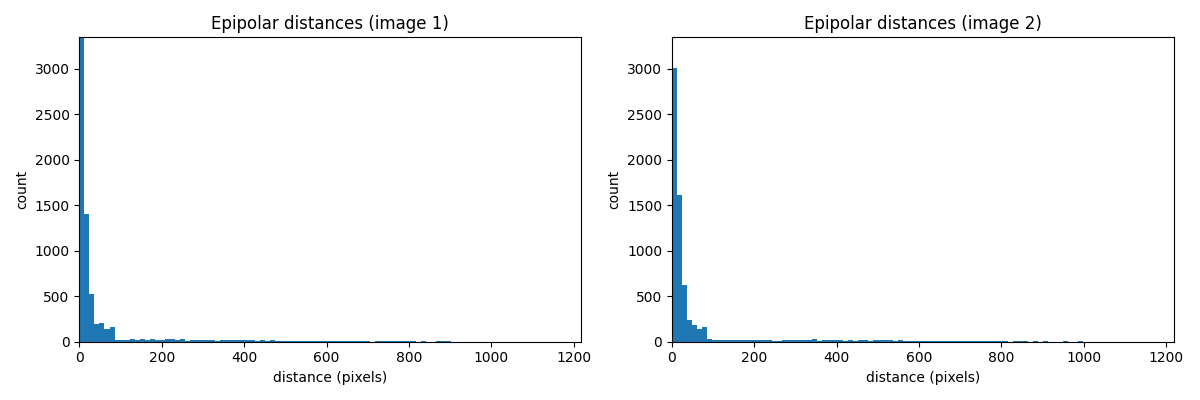

In [61]:
# ------ Your code here ------

import matplotlib.pyplot as plt
import numpy as np


mean_d1, mean_d2 = np.mean(d1), np.mean(d2)
med_d1, med_d2 = np.median(d1), np.median(d2)
max_d1, max_d2 = np.max(d1), np.max(d2)

print(f"Image1: mean = {mean_d1:.3f} px, median = {med_d1:.3f} px, max = {max_d1:.3f} px")
print(f"Image2: mean = {mean_d2:.3f} px, median = {med_d2:.3f} px, max = {max_d2:.3f} px")


x_max = max(max_d1, max_d2)
y_max = max(
    np.histogram(d1, bins=100, range=(0, x_max))[0].max(),
    np.histogram(d2, bins=100, range=(0, x_max))[0].max()
)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(d1, bins=100, range=(0, x_max))
plt.title("Epipolar distances (image 1)")
plt.xlabel("distance (pixels)")
plt.ylabel("count")
plt.xlim(0, x_max)
plt.ylim(0, y_max)

plt.subplot(1,2,2)
plt.hist(d2, bins=100, range=(0, x_max))
plt.title("Epipolar distances (image 2)")
plt.xlabel("distance (pixels)")
plt.ylabel("count")
plt.xlim(0, x_max)
plt.ylim(0, y_max)

plt.tight_layout()
plt.show()


### Task 1.4

Pick 20 points in the first image at random and plot these in the same figure as the image. Also plot the corresponding epipolar lines in the same image using the function `rital`. Repeat the plot for the second image.

Q: **Do the plots look reasonable, are points close to the epipolar lines? If not, what do you think could be the cause of the bad estimate?** 

A: [Insert your answer]

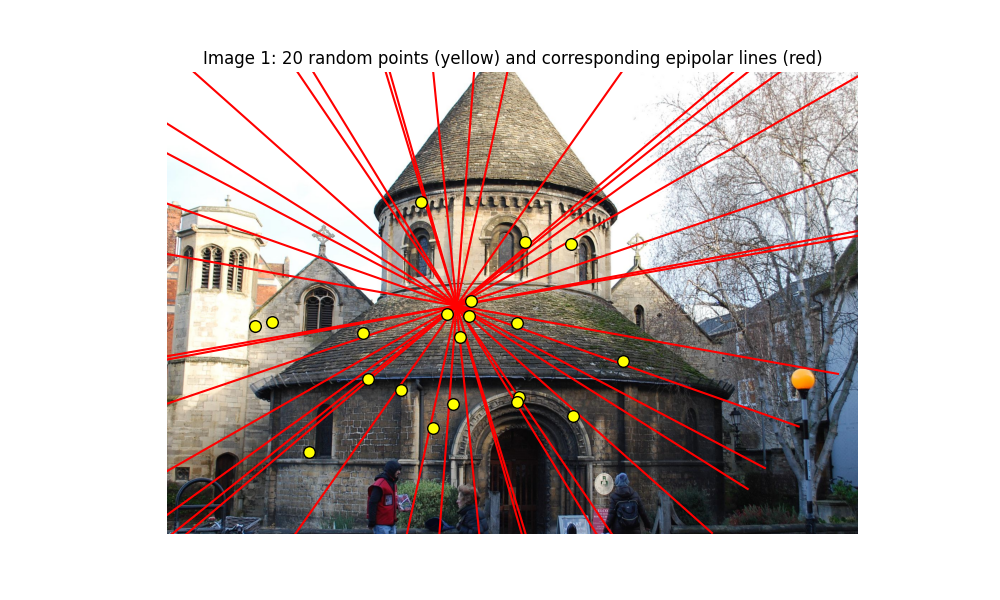

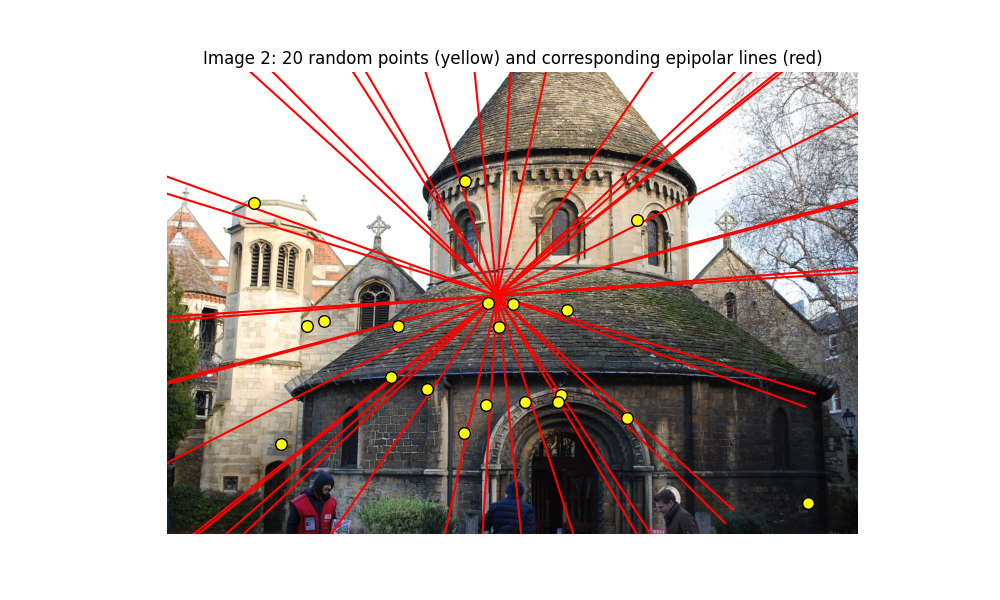

In [62]:
# ------ Your code here ------


import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)  
m = x1.shape[1]
idx = rng.choice(m, size=min(20, m), replace=False)


# l2 are lines in image 2 corresponding to x1
# l1 are lines in image 1 corresponding to x2
l2 = F @ x1
l1 = F.T @ x2


plt.figure(figsize=(10,6))
plt.imshow(img1)
pts1_x = x1[0, idx] / x1[2, idx]
pts1_y = x1[1, idx] / x1[2, idx]
plt.scatter(pts1_x, pts1_y, s=70, c='yellow', edgecolor='k', zorder=3)

rital(l1[:, idx].T, 'r-')
plt.title("Image 1: 20 random points (yellow) and corresponding epipolar lines (red)")
plt.axis('off')
plt.show()


plt.figure(figsize=(10,6))
plt.imshow(img2)
pts2_x = x2[0, idx] / x2[2, idx]
pts2_y = x2[1, idx] / x2[2, idx]
plt.scatter(pts2_x, pts2_y, s=70, c='yellow', edgecolor='k', zorder=3)
rital(l2[:, idx].T, 'r-')
plt.title("Image 2: 20 random points (yellow) and corresponding epipolar lines (red)")
plt.axis('off')
plt.show()


Task 1.4 Question: Do the plots look reasonable, are points close to the epipolar lines? If not, what do you think could be the cause of the bad estimate?

Our thoughts: 
No, the plots most of the times do not look reasonable. In both images, most of the yellow points are far away from their corresponding red epipolar lines. Some lines pass through completely unrelated regions of the image, and many lines intersect at a single point, indicating a poorly estimated epipole.

This happens because the essential matrix was computed using all correspondences, including many outliers and noisy matches. The eight-point algorithm is not robust, so even a few incorrect correspondences can strongly distort the estimation. As a result, the fundamental matrix and the epipolar lines become inaccurate.

### Task 1.5

Next, use RANSAC to robustly compute $E$. Create a function `estimate_E_robust(x1, x2, eps)` that does it, where `eps` is the inlier threshold. Remember again to normalize `x1` and `x2` using $K$ beforehand. Note that for this problem of estimating $E$, a point correspondence $({\mathbf{x}_1}_i, {\mathbf{x}_2}_i)$ is a single measurement. Use the same eight point solver as above.

Note that this time only a subset of correspondences will be used by this solver (since in the RANSAC loop, you first randomly sample a subset of correspondences and then compute candidate $E$ from this subset).

Finally, to make RANSAC work, you need to implement an error function that measures how far a single measurement ($({\mathbf{x}_1}_i, {\mathbf{x}_2}_i)$) is to the candidate model ($E$). Use the following error function: $\frac12 \left ( d^2({\mathbf{x}_1}_i,{\mathbf{l}_1}_i) + d^2({\mathbf{x}_2}_i,{\mathbf{l}_2}_i)\right )$, where the epipolar lines ${\mathbf{l}_j}_i$ are computed as before but using $E$ (and therefore are normalized). This error should be familiar to you based on the previous exercises, reuse your implementation from there!

A suggested inlier threshold is 2px (which should also be normalized, see function description below). 

Q: **How many inliers did you get for the returned solution of $E$?**

A: [Insert your answer]

In [63]:
# ------ Your code here ------

import numpy as np

def estimate_E_robust(x1, x2, eps, seed=None):
    """
    RANSAC estimate of essential matrix using normalized correspondences.

    Parameters
    ----------
    x1, x2 : 3xN ndarray
        Normalized image points (K^{-1} x) in homogeneous coordinates.
    eps : float
        Normalized inlier threshold.
    seed : int or None
        Random seed for reproducibility.

    Returns
    -------
    E : 3x3 ndarray
        Estimated essential matrix.
    inliers : ndarray (bool)
        Boolean mask indicating inlier correspondences.
    errs : ndarray
        Per-point symmetric epipolar error.
    iters : int
        Number of RANSAC iterations.
    """
    rng = np.random.default_rng(seed)
    N = x1.shape[1]
    max_iters = 2000

    best_inliers = None
    best_count = 0
    best_E = None

    for it in range(max_iters):
        
        idx = rng.choice(N, size=8, replace=False)

        
        E_approx, _, _, _ = estimate_F_DLT(x1[:, idx], x2[:, idx])
        E_candidate = enforce_essential(E_approx)

        
        d2 = compute_epipolar_errors(E_candidate, x1, x2)
        d1 = compute_epipolar_errors(E_candidate.T, x2, x1)
        errs = 0.5 * (d1**2 + d2**2)

        
        inliers = errs < eps**2
        count = np.sum(inliers)

        
        if count > best_count:
            best_count = count
            best_inliers = inliers
            best_E = E_candidate

    
    inlier_idx = np.where(best_inliers)[0]
    E_ref_approx, _, _, _ = estimate_F_DLT(x1[:, inlier_idx], x2[:, inlier_idx])
    E = enforce_essential(E_ref_approx)

    
    d2 = compute_epipolar_errors(E, x1, x2)
    d1 = compute_epipolar_errors(E.T, x2, x1)
    errs = 0.5 * (d1**2 + d2**2)

    return E, best_inliers, errs, max_iters



x1_cal = np.linalg.inv(K) @ x1
x2_cal = np.linalg.inv(K) @ x2


eps = 2.0 / K[0,0]


E_ransac, inliers, errs, iters = estimate_E_robust(x1_cal, x2_cal, eps, seed=0)

print("Number of inliers:", np.sum(inliers))



Number of inliers: 5801


### Task 1.6

Again, compute the RMS distance between the image points and corresponding estimated epipolar lines in both images. Also plot a histogram of epipolar errors for both images as before. 

Q: **Which is the better estimate of the essential matrix, and why?** Repeat plotting 20 random points with the corresponding epipolar lines, but this time pick random points from the subset of correspondences that are ***inliers***.

A: The RANSAC-based estimate is better. The non-robust eight-point solution (using all matches) produced a large RMS (~156 px) due to many outliers. RANSAC removes outliers and fits E using inliers only, resulting in 728 inliers and an inlier RMS ≈ 1.36 px. The much lower RMS and the visual alignment of points with epipolar lines confirm the robust estimate is superior.


Total matches: 6822
Inliers: 5801
Inlier RMS (recomputed): 0.3859359020715805
Inlier mean d1,d2: 0.28451757077009443 0.3195702135304885
Inlier median d1,d2: 0.23955797888357036 0.27272311133956034


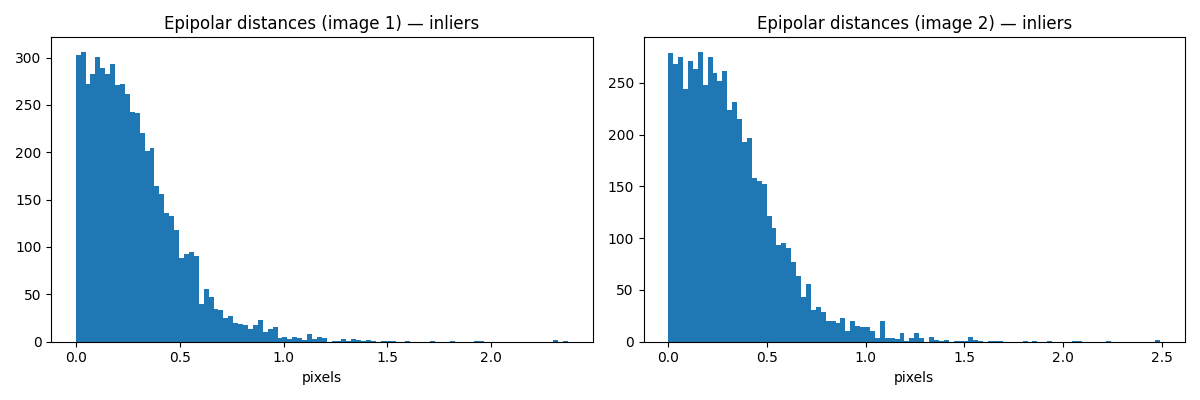

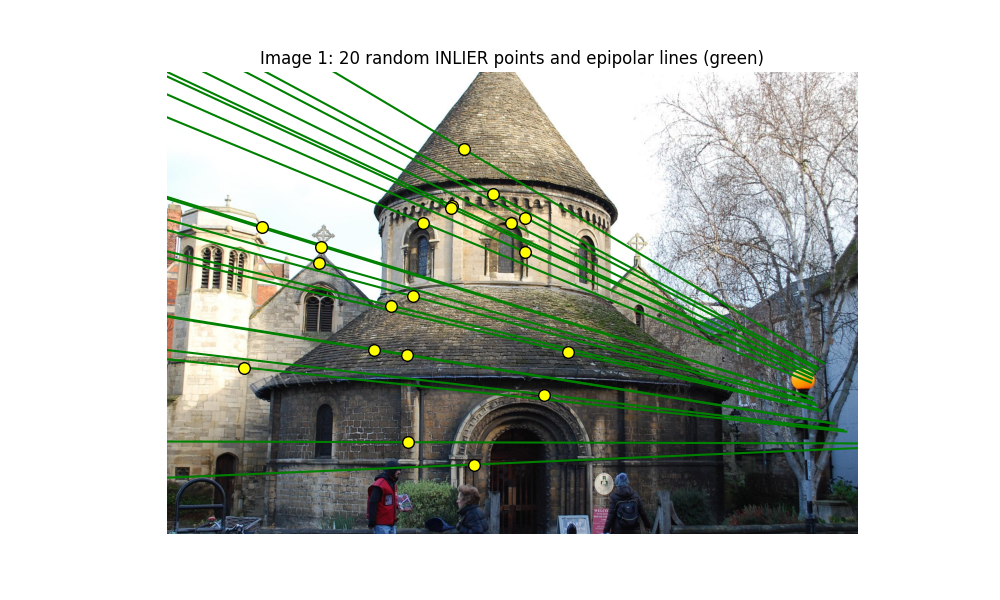

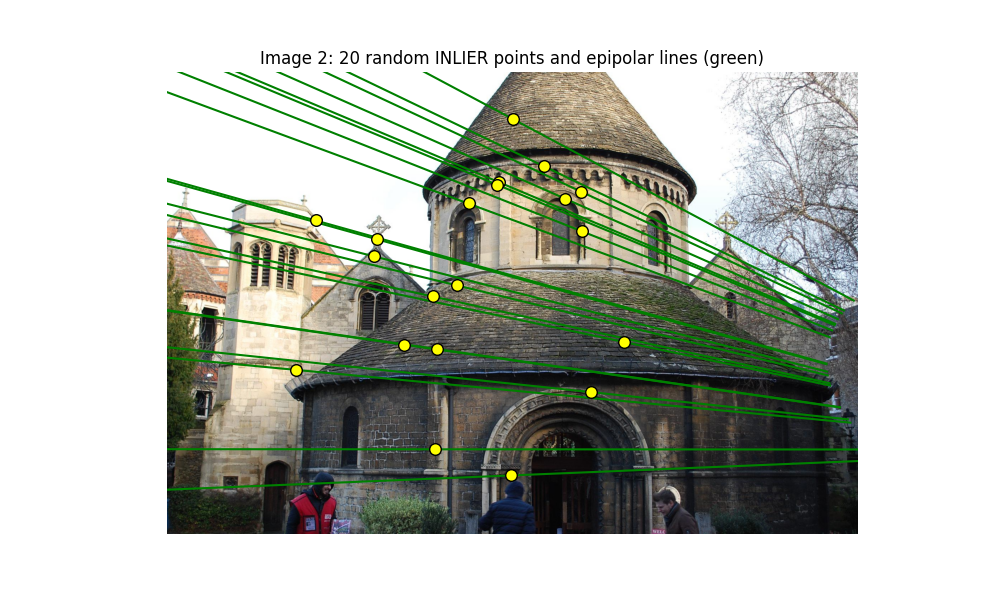

In [64]:
# ------ Your code here ------


F_ransac = convert_E_to_F(E_ransac, K, K)
F_ransac = enforce_fundamental(F_ransac)
F_ransac = F_ransac / np.linalg.norm(F_ransac)


d2_all = compute_epipolar_errors(F_ransac, x1, x2)     
d1_all = compute_epipolar_errors(F_ransac.T, x2, x1)   


#inlier_idx = np.where(inliers_mask)[0]
inlier_idx = np.where(inliers)[0]

print("Total matches:", x1.shape[1])
print("Inliers:", inlier_idx.size)
print("Inlier RMS (recomputed):", np.sqrt((np.sum(d1_all[inlier_idx]**2) + np.sum(d2_all[inlier_idx]**2)) / (2.0 * inlier_idx.size)))
print("Inlier mean d1,d2:", np.mean(d1_all[inlier_idx]), np.mean(d2_all[inlier_idx]))
print("Inlier median d1,d2:", np.median(d1_all[inlier_idx]), np.median(d2_all[inlier_idx]))


import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(d1_all[inlier_idx], bins=100)
plt.title("Epipolar distances (image 1) — inliers")
plt.xlabel("pixels")
plt.subplot(1,2,2)
plt.hist(d2_all[inlier_idx], bins=100)
plt.title("Epipolar distances (image 2) — inliers")
plt.xlabel("pixels")
plt.tight_layout()
plt.show()


rng = np.random.default_rng(1)
m_in = inlier_idx.size
idx20 = rng.choice(inlier_idx, size=min(20, m_in), replace=False)


l2_in = F_ransac @ x1   
l1_in = F_ransac.T @ x2 


plt.figure(figsize=(10,6))
plt.imshow(img1)
pts1_x = x1[0, idx20] / x1[2, idx20]
pts1_y = x1[1, idx20] / x1[2, idx20]
plt.scatter(pts1_x, pts1_y, s=70, c='yellow', edgecolor='k', zorder=3)
rital(l1_in[:, idx20].T, 'g-')   # green for inlier epipolar lines
plt.title("Image 1: 20 random INLIER points and epipolar lines (green)")
plt.axis('off')
plt.show()


plt.figure(figsize=(10,6))
plt.imshow(img2)
pts2_x = x2[0, idx20] / x2[2, idx20]
pts2_y = x2[1, idx20] / x2[2, idx20]
plt.scatter(pts2_x, pts2_y, s=70, c='yellow', edgecolor='k', zorder=3)
rital(l2_in[:, idx20].T, 'g-')
plt.title("Image 2: 20 random INLIER points and epipolar lines (green)")
plt.axis('off')
plt.show()


## Computer Exercise 2
<figure align="center">
    <img alt="left" src="data/fountain1.png" width="250px">
&nbsp; &nbsp; &nbsp; &nbsp;
    <img alt="right" src="data/fountain2.png" width="250px">
    <img alt="right" src="data/fountain_recon.png" width="250px">
    <figcaption>Figure 2: Two images of a fountain and an example of the obtained 3D reconstruction.</figcaption>
</figure>

In this exercise you will build a 2-view reconstruction pipeline that connects feature extraction,
matching, robust essential matrix estimation from the previous computer exercise, and triangulation.

You can use the two supplied images from the data and the intrinsics provided. We load the required data for your convenience below:

In [65]:
data = sp.io.loadmat('./data/compEx2data.mat')
K = data['K']
img1 = (plt.imread('./data/fountain1.png') * 255).astype('uint8')
img2 = (plt.imread('./data/fountain2.png') * 255).astype('uint8')

### Task 2.1

We will begin by computing SIFT features and matching them. Since OpenCV has quite a difficult API for this we have supplied some code snippets. And you already learned much of the basics of this from Assignment 2, so we provide some basic code to get you started.

The implementation is based on their official guide for image matching (https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html) and uses Lowe's ratio test to filter out matches that are too similar, this should be similar to what you have done in previous assignments.

In [66]:


from cv2 import SIFT_create, cvtColor, COLOR_RGB2GRAY, FlannBasedMatcher, drawMatchesKnn
rgb2gray = lambda img: cvtColor(img, COLOR_RGB2GRAY)
sift = SIFT_create(contrastThreshold=0.02, edgeThreshold=10, nOctaveLayers=3)


kp1, des1 = sift.detectAndCompute(rgb2gray(img1),None)
kp2, des2 = sift.detectAndCompute(rgb2gray(img2),None)


all_matches = FlannBasedMatcher().knnMatch(des1, des2, k=2)

# Here we filter out matches that are too similar to other matches (because then they are likely wrong)
# This is standard in OpenCV, see https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
matches = []
for m,n in all_matches:
    if m.distance < 0.75*n.distance:
        matches.append([m])

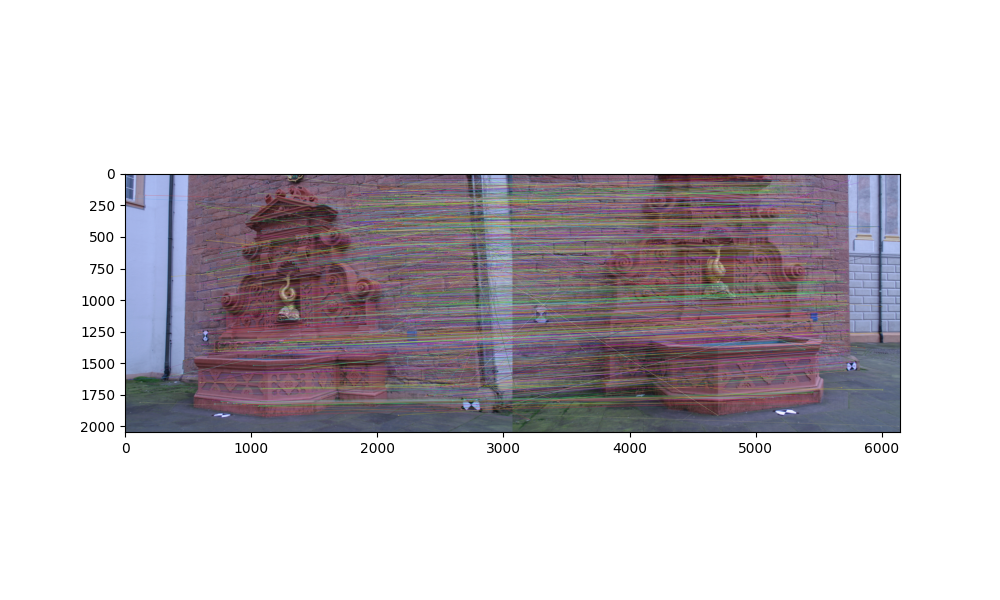

(<matplotlib.image.AxesImage at 0x164949050>, None)

In [67]:
# Run this code for a simple plot of the filtered matches

# Just making sure no other figures are impacting this one
plt.close()
plt.clf()   
plt.cla() 
# Here is some supplied code from https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
# Feel free to play around with it
img3 = drawMatchesKnn(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3,),plt.show()

Q: **Run the code above. Do the matches look reasonable?**

A: 
Yes, the matches look reasonable. Most correspondences connect visually similar structures in the two images, and the ratio test successfully removes many incorrect matches. While some mismatches remain, the majority of matches appear geometrically consistent and suitable for further processing using RANSAC.

Q: **How many SIFT features did you find for the two images, respectively? How many total matches did you find? How many good matches did you find after the ratio test?**

A: 
Number of SIFT features in image 1: 19408  

Number of SIFT features in image 2: 17616 

Total matches (before ratio test): 19408

Good matches (after ratio test): 1038

In [68]:
# ------ Your code here ------

# Count SIFT features per image

# Count number of total matches

# Count the number of good matches after the ratio-test




num_kp1 = len(kp1)
num_kp2 = len(kp2)


num_total_matches = len(all_matches)


num_good_matches = len(matches)

print(f"Number of SIFT features in image 1: {num_kp1}")
print(f"Number of SIFT features in image 2: {num_kp2}")
print(f"Total matches (before ratio test): {num_total_matches}")
print(f"Good matches (after ratio test): {num_good_matches}")


Number of SIFT features in image 1: 19408
Number of SIFT features in image 2: 17616
Total matches (before ratio test): 19408
Good matches (after ratio test): 1038


Now we supply a little more code just to make it easier. We extract the keypoints corresponding to the good matches and save them as x1 and x2. We do this because currently the type of kp1 etc... are OpenCV specific

In [69]:
# Supplied code for extracting numpy arrays from matching keypoints
# Note, x1 and x2 are in homogenous coordinates after this
x1 = np.array([[kp1[match[0].queryIdx].pt[0], kp1[match[0].queryIdx].pt[1]] for match in matches])
x2 = np.array([[kp2[match[0].trainIdx].pt[0], kp2[match[0].trainIdx].pt[1]] for match in matches])
x1 = np.vstack((x1.T, np.ones(x1.shape[0])))
x2 = np.vstack((x2.T, np.ones(x2.shape[0])))
x = np.array([x1, x2])

### Task 2.2

Now you should find the essential matrix describing the transformation between the two images.
Because not all matches are correct, you need to use RANSAC to find a set of good correspondences (inliers). 
To estimate the essential matrix use the function `estimate_E_robust(x1,x2,eps)` that you created in the previous computer exercise.

Q: **How many inliers did you find?**

A: 
Using RANSAC with an inlier threshold of 2 pixels, the robust estimation of the essential matrix resulted in 464 inliers. This indicates that a substantial subset of the SIFT matches is geometrically consistent and suitable for reliable two-view reconstruction.

In [70]:
# ------ Your code here ------


x1_cal = np.linalg.inv(K) @ x1
x2_cal = np.linalg.inv(K) @ x2


eps = 2.0 / K[0,0]


E_ransac, inliers, errs, iters = estimate_E_robust(x1_cal, x2_cal, eps, seed=0)


num_inliers = np.sum(inliers)
print(f"Number of inliers: {num_inliers}")


Number of inliers: 464


### Task 2.3

After getting the robust essential matrix estimation, you should find the camera matrix of the second view. Remember that there are 4 possible solutions (see Theoretical Exercise 7 of HA3)! You should pick the solution that has more points in front of the camera. Remember, in Assigment 3 you implemented `extract_P_from_E(E)`

**Hint:** You need to perform triangulation by using a function from a previous computer exercise. The 3D points X and the 2d correspondences x1 and x2 wil also be needed for the next task in this assignment!

Q: **Which of the solutions seems correct to you?**

A: [Insert your answer]

In [71]:
# Optional import
#from helpers import extract_P_from_E, triangulate_3D_point_DLT
from helpers import extract_P_from_E, triangulate_DLT


Points in front of both cameras for each solution: [np.int64(0), np.int64(0), np.int64(0), np.int64(464)]
Selected solution index: 3
Number of valid points: 464


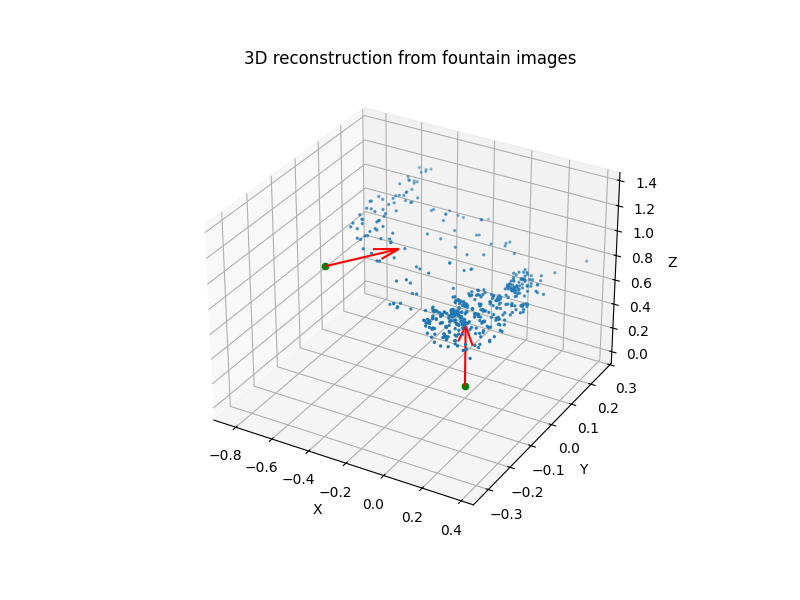

In [72]:



P1 = np.hstack((np.eye(3), np.zeros((3, 1))))


P2_candidates = extract_P_from_E(E_ransac)


x1_in = x1_cal[:, inliers]
x2_in = x2_cal[:, inliers]

counts = []
Xs = []


for i in range(4):
    P2 = P2_candidates[i]


    X = triangulate_DLT(P1, P2, x1_in, x2_in)
    Xs.append(X)


    X3 = X[:3, :]
    z1 = X3[2, :]
    z2 = (P2[:, :3] @ X3 + P2[:, 3:4])[2, :]

    counts.append(np.sum((z1 > 0) & (z2 > 0)))


best_idx = np.argmax(counts)
P2_best = P2_candidates[best_idx]
X_best = Xs[best_idx]

print("Points in front of both cameras for each solution:", counts)
print("Selected solution index:", best_idx)
print("Number of valid points:", counts[best_idx])


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_best[0, :], X_best[1, :], X_best[2, :], s=2)


plot_camera(P1, 0.5, ax)
plot_camera(P2_best, 0.5, ax)

ax.set_title("3D reconstruction from fountain images")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()


### Summary of reconstruction pipeline

In summary, you have performed a 2d-view reconstruction pipeline consisting of the following steps:
1. **Load the two images**, find SIFT features, and match them.

2. **Estimate the essential matrix** robustly using  
   `estimate_E_robust(x1, x2, eps)`.

3. **Compute the four possible camera matrix pairs** for the essential matrix, and for each pair:
   1. Triangulate the 3D points using the camera matrix pair and the matched image points.
   2. Compute the camera centers and principal directions of both cameras.
   3. Plot everything in 3D.

4. **Choose the correct solution** (out of the four) by selecting the one that yields the highest number of 3D points (inliers) lying in front of the cameras.  

The final visualization should resemble the right-most result in the first Figure of Computer Exercise 2 after removing most outliers.

This pipeline will come in handy for the project and somewhat resembles the first stage in any modern SfM pipeline like [COLMAP](https://github.com/colmap/colmap).

#### *Theoretical exercises 3* (see pdf)

## Computer Exercise 3

In this exercise you will use the solution from Computer Exercise 2 as a starting point and locally improve it using the Levenberg-Marquardt method. If you have doubts about the correctness of your solution from the earlier exercise, you can instead use the provided data in `compEx3data.mat` as starting solution (you can load it like `data = sp.io.loadmat('./data/compEx3data.mat')` and then use that for your x and camera matrices).

The goal is to refine the solution **3D points (not camera matrices, those you can assume fixed**).
You will loop over the 3D points and update them one by one using Levenberg-Marquardt (LM), please see the lecture notes or [Wikipedia page on Levenberg–Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) for more information.

In short, LM is an iterative method for minimizing a non-linear least squares objective
\begin{equation}
   F(v)=\|r(v)\|^2, 
\end{equation}
with respect to $v$.
In LM, the update is given by
\begin{equation}
\delta v =  - (J(v)^TJ(v)+\mu I)^{-1}J(v)^Tr(v),
\end{equation}
where $J(v)$ is the Jacobian of $r(v)$ at $v$.
Here $\mu>0$ is a damping factor that is adjusted adaptively and $v$ is the previous solution.
The new solution is $v+\delta v$ and we iterate until convergence (or for a fixed number of iterations).

We can also define the **reprojection error** to be: $\sum_{i=1}^m \left\|r_{i}(X_j) \right\|^2 $ (as in Equation (2) in the Theoretical Exercises)

In our setting, we have $v=X_j$ and $r(v)=r(X_j)$. Please see the main PDF for some more details about the definition of $r$ (e.g. Equation (3) for the definition).

You will have to implement three functions in this exercise:

1. `(err,res) = compute_reprojection_error(P_1,P_2,X_j,x_1j,x_2j)`: a function that computes the reprojection error ($\sum_{i=1}^m \left\|r_{i}(X_j) \right\|^2 $) given two cameras $P_i$, a 3D point $X_j$ and 2D points $x_{ij}$ in the images corresponding to the cameras $P_i$ and the 3D point $X_j$. It also returns the values of all the individual residuals as a second output, i.e., the residual vector $r(\mathbf{X}_j)$.
    
2. `(r,J) = linearize_reproj_err(P_1,P_2,X_j,x_1j,x_2j)`: a function that computes the linearization ($r$ and $J$) as described in Equation (7) in the Theoretical Exercises.
    
3. `delta_X_j = compute_update(r, J, mu)`: a function that computes the LM-update given $r$, $J$ and $\mu$ as described in Equation (9) in the Theoretical Exercises.

The idea is now to use *decoupled* LM, i.e. loop over the 3D points and refine them one by one.

Let's first start by implementing the functions in code!

**NOTE**: Below we have provided suggestion for the function signatures. However, you are free to implement the actual functions however you'd like. For example, you don't have to take the inputs and outputs on the exact form we suggest. This is one way to store the Jacobians, residuals, etc..., feel free to decide how you feel is best.

In [73]:
#Random useful commands:

#Computes the LM update .
C = J.T @ J + mu * np.eye(J.shape[1])
c = J.T @ r
delta = -np.linalg.solve(C, c)

In [74]:
# def compute_reprojection_error(P_1, P_2, X_j, x_1j, x_2j):
#     """
#     Compute the reprojection error for a single 3D point.

#     Parameters
#     ----------
#     P_1, P_2 : ndarray (3, 4)
#         Projection matrices.

#     X_j : ndarray (4,)
#         3D homogeneous point.

#     x_1j, x_2j : ndarray (2,)
#         Observed image positions.

#     Returns
#     -------
#     err : float 
#         Reprojection error.

#     r : Residual vector. For example, an ndarray of shape (2, 2)
#         However, you can decide in your own implementation.
#     """
    

In [75]:
# def linearize_reproj_err(P_1, P_2, X_j, x_1j, x_2j):
#     """
#     Linearize the reprojection error for a single 3D point observed in two views.

#     Parameters
#     ----------
#     P_1, P_2 : ndarray (3, 4)
#         Camera matrices.

#     X_j : ndarray (4,)
#         Homogeneous 3D point.

#     x_1j, x_2j : ndarray (2,)
#         Observed image coordinates for this point in cameras 1 and 2.

#     Returns
#     -------
#     r : Linearization of r. For example an ndarray of shape (4,) representing concatenated reprojection residuals: [r1_x, r1_y, r2_x, r2_y].
#         However, you can decide for yourself how you want to store this.

#     J : Linearization of J. For example, an ndarray of shape (4, 4) representing a concatenation of the two Jacobians
#         However, you can decide for yourself how you want to store this.

#     Notes
#     -----
#     This creates the linear system used in Levenberg-Marquardt.
#     """
# return r0, J

    


In [76]:
# ------ Your code here ------

# Print the median reprojection error before bundle adjustment

# Perform bundle adjustment by looping through your N points
# For each point, compute the Levenberg-Marquadt update
# Use the update to update the 3D point (the camera matrices are fixed!)

# Print the median reprojection error after bundle adjustment

# Plot the refined 3D points in the same plot as the originals

Median reprojection error before LM: 2.1806093809040092
Median reprojection error after LM: 2.102878904962731


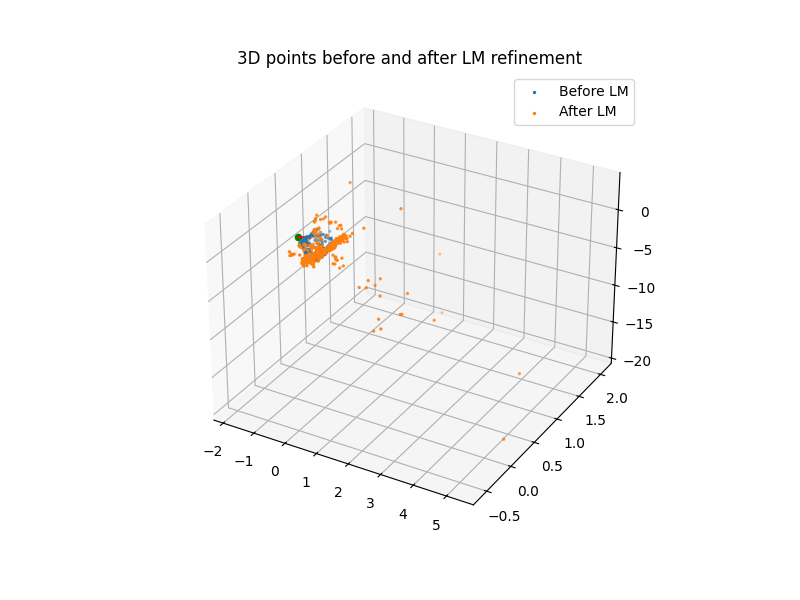

In [ ]:


def project_point(P, X):
    """
    Project a homogeneous 3D point X using camera matrix P.
    Returns inhomogeneous image coordinates (2,)
    """
    x = P @ X
    x = x / x[2]
    return x[:2]


def compute_reprojection_error(P1, P2, X, x1, x2):
    """
    Compute reprojection error and residual vector for one 3D point.
    """
    x1_proj = project_point(P1, X)
    x2_proj = project_point(P2, X)

    r1 = x1_proj - x1
    r2 = x2_proj - x2

    r = np.hstack((r1, r2))
    err = np.sum(r**2)

    return err, r


def linearize_reproj_err(P1, P2, X, x1, x2, eps=1e-6):
    """
    Numerical Jacobian of reprojection residuals w.r.t. X
    """
    _, r0 = compute_reprojection_error(P1, P2, X, x1, x2)
    J = np.zeros((4, 4))

    for i in range(4):
        dX = np.zeros(4)
        dX[i] = eps
        _, r1 = compute_reprojection_error(P1, P2, X + dX, x1, x2)
        J[:, i] = (r1 - r0) / eps

    return r0, J


def compute_update(r, J, mu):
    """
    Levenberg–Marquardt update step
    """
    C = J.T @ J + mu * np.eye(J.shape[1])
    c = J.T @ r
    delta = -np.linalg.solve(C, c)
    return delta




# Use pixel-space camera matrices
P1_pix = K @ P1
P2_pix = K @ P2_best

X_refined = X_best.copy()
mu = 1e-3
num_iters = 10

# Compute reprojection error before LM
errors_before = []

for i in range(X_best.shape[1]):
    X = X_best[:, i]
    x1i = (x1[:, inliers][:2, i]).astype(float)
    x2i = (x2[:, inliers][:2, i]).astype(float)
    err, _ = compute_reprojection_error(P1_pix, P2_pix, X, x1i, x2i)
    errors_before.append(err)

print("Median reprojection error before LM:", np.median(errors_before))


# LM loop
for it in range(num_iters):
    for i in range(X_refined.shape[1]):
        X = X_refined[:, i]
        x1i = (x1[:, inliers][:2, i]).astype(float)
        x2i = (x2[:, inliers][:2, i]).astype(float)

        r, J = linearize_reproj_err(P1_pix, P2_pix, X, x1i, x2i)
        delta = compute_update(r, J, mu)
        X_refined[:, i] = X + delta

# Compute reprojection error after LM
errors_after = []

for i in range(X_refined.shape[1]):
    X = X_refined[:, i]
    x1i = (x1[:, inliers][:2, i]).astype(float)
    x2i = (x2[:, inliers][:2, i]).astype(float)
    err, _ = compute_reprojection_error(P1_pix, P2_pix, X, x1i, x2i)
    errors_after.append(err)

print("Median reprojection error after LM:", np.median(errors_after))




fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_best[0], X_best[1], X_best[2], s=2, label="Before LM")
ax.scatter(X_refined[0], X_refined[1], X_refined[2], s=2, label="After LM")

plot_camera(P1, 0.5, ax)
plot_camera(P2_best, 0.5, ax)

ax.set_title("3D points before and after LM refinement")
ax.legend()
plt.show()


Compare the total reprojection error (sum of $\sum_{i=1}^m \left\|r_{i}(X_j) \right\|^2 $ over all 3D points) before and after running LM.
Also compare the median reprojection error (median of $\sum_{i=1}^m \left\|r_{i}(X_j) \right\|^2 $ over all 3D points) before and after running LM.

Finally plot the refined 3D points in the same plot as the originals.

Q: **What do you observe?**

The reprojection error decreases slightly after LM, indicating that the initial solution was already close to a local minimum. LM mainly performs a local refinement of the 3D points while preserving the overall structure.

## **OPTIONAL**: Computer Exercise 4 (10 points)

Perform an empirical noise sensitivity analysis of your LM-solver from the previous exercise.
Add i.i.d. mean-zero Gaussian noise with standard deviation $\sigma_X\in\{0,0.1\mathrm{m}\}$ to the 3D points and $\sigma_x\in\{0,3\mathrm{px}\}$ to the 2D points (from SIFT), yielding (at least) four noise combinations ($\sigma_X$, $\sigma_x$) to try.
See how the total reprojection error and median reprojection error as computed in the previous exercise varies before and after LM with the added noise.
If you want to, you can test other noise types as well.

Q: **Report your findings with plots and numbers in some reasonable manner.**

A: [Insert your answer]

In [78]:
# ------ Your code here ------